# uniD (LevelX)

## About

The uniD dataset was created and published by a team from the Institute for Automotive Engineering (ika) of RWTH Aachen University to promote research in many different domains of mobility. The dataset can therefore be downloaded and used free of charge for academic and research purposes.

This dataset contains over 1380 vehicles and 8600 vulnerable road users (VRUs) extracted from drone video recordings at shared space next to university. At one location, 13 recordings were made.

### How to apply

The uniD dataset is free for non-commercial use only. According to the license and protocols, as a third-party, we cannot share any form of this dataset online. Please visit [the official website](https://levelxdata.com/unid-dataset/) of uniD, fill in the application form and send your request.

### Citation

```latex
@misc{unidDataset,
    title={{uniD}: The University Drone Dataset},
    author={leveLXData by fka GmbH},
    howpublished= {\url{https://levelxdata.com/unid-dataset/}},
    year = {2021}
}
```

## Data Analysis

> This part is independently conducted by Tactics2D.

In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import polars as pl
import numpy as np
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Setting up parameters for matplotlib
mpl.rcParams.update(
    {
        "figure.dpi": 200,  # 200 for high quality
        "font.family": "DejaVu Sans Mono",
        "font.size": 6,
        "font.stretch": "semi-expanded",
        "animation.html": "jshtml",
        "animation.embed_limit": 5000,
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": "#cccccc",
        "axes.facecolor": "white",
    }
)

hue_order = ["car", "truck", "trailer", "bus", "van", "motorcycle", "bicycle", "pedestrian", "animal"]

In [3]:
dfs_meta = pd.DataFrame()
for i in range(13):
    df_meta = pd.read_csv("../../data/uniD/data/%02d_recordingMeta.csv" % i)
    dfs_meta = pd.concat([dfs_meta, df_meta], ignore_index=True)

In [4]:
dfs_track_meta = pd.DataFrame()
for i in range(13):
    df_track_meta = pd.read_csv("../../data/uniD/data/%02d_tracksMeta.csv" % i)
    df_track_meta["fileId"] = i
    dfs_track_meta = pd.concat([dfs_track_meta, df_track_meta], ignore_index=True)

In [5]:
dfs = pl.DataFrame()

for i in range(13):
    df = pl.read_csv("../../data/uniD/data/%02d_tracks.csv" % i)
    df = df.select(["trackId", "frame", "xCenter", "yCenter", "heading", "xVelocity", "yVelocity"])
    df = df.with_columns(pl.lit(i).alias("fileId"))
    df = df.join(
        pl.DataFrame(dfs_track_meta)[["fileId", "trackId", "class"]],
        on=["fileId", "trackId"],
        how="left",
    )

    dfs = pl.concat([dfs, df])

In [6]:
x_min = np.floor(dfs["xCenter"].min())
x_max = np.ceil(dfs["xCenter"].max())
y_min = np.floor((-dfs["yCenter"]).min())
y_max = np.ceil((-dfs["yCenter"]).max())
vx = dfs["xVelocity"].to_numpy()
vy = dfs["yVelocity"].to_numpy()

x_edges = np.linspace(x_min, x_max, num=int((x_max - x_min) * 10 + 1), endpoint=True)
y_edges = np.linspace(y_min, y_max, num=int((y_max - y_min) * 10 + 1), endpoint=True)
x_bin = np.digitize(dfs["xCenter"].to_numpy(), x_edges) - 1
y_bin = np.digitize((-dfs["yCenter"]).to_numpy(), y_edges) - 1

speed = np.sqrt(vx**2 + vy**2)

dfs = dfs.with_columns(
    [pl.Series("x_bin", x_bin), pl.Series("y_bin", y_bin), pl.Series("speed (m/s)", speed)]
)

### Distribution of Trajectory on Map

By projecting the trajectories onto the image version of the map, it becomes clear that the predominant trajectory type in uniD is pedestrian. The pedestrians move freely along the road, showcasing their behavior patterns on roads with sparse vehicle traffic.

![Trajectories on map](https://raw.githubusercontent.com/MotacillaAlba/image-storage/main/img/uniD.jpeg)

### Distribution of Trajectory Categories

We show the proportion of different categories of traffic participants in each file. It can be seen that pedestrian, car, and bicycle trajectories make up the majority of the uniD dataset. The proportion of each category varies within a certain range across files.

In [7]:
df_class_distribution = (
    dfs_track_meta.groupby("fileId")["class"].value_counts(normalize=True).unstack(fill_value=0)
)

df_class_distribution_melted = df_class_distribution.reset_index().melt(
    id_vars="fileId", var_name="class", value_name="proportion (%)"
)
df_class_distribution_melted["location"] = 0
df_class_distribution_melted["location"] = pd.Categorical(
    df_class_distribution_melted["location"], categories=[0], ordered=True
)

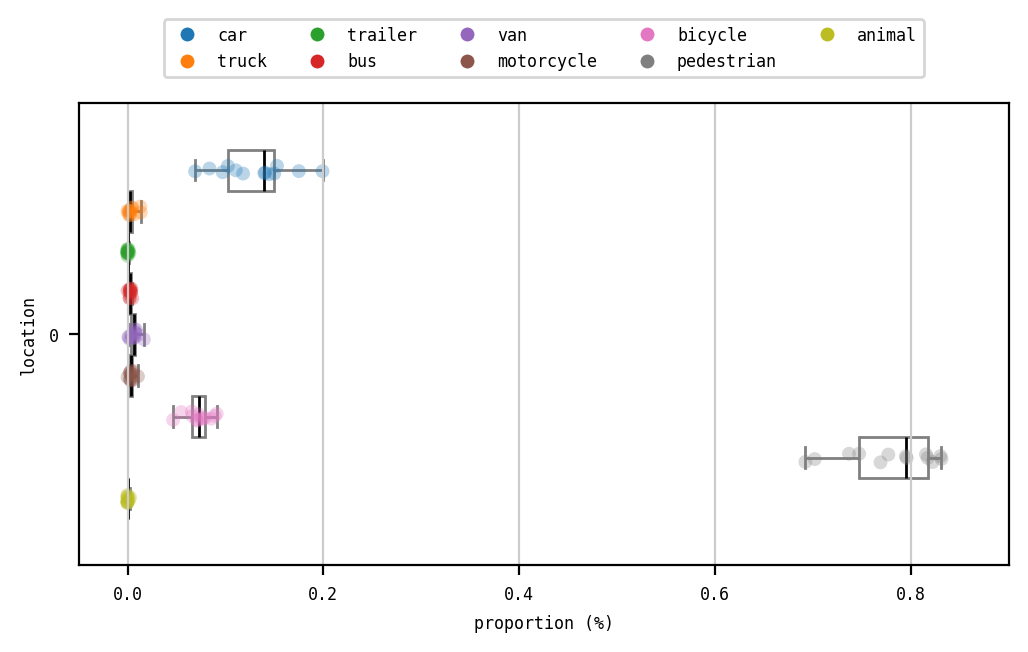

In [8]:
fig, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(
    data=df_class_distribution_melted,
    x="proportion (%)",
    y="location",
    hue="class",
    hue_order=hue_order,
    dodge=True,
    linewidth=1,
    fliersize=0,
    whis=[0, 100],
    ax=ax,
    zorder=0,
    boxprops=dict(facecolor="none", edgecolor="gray"),
    medianprops=dict(color="black"),
    whiskerprops=dict(color="gray"),
    capprops=dict(color="gray"),
    legend=False
)

sns.stripplot(
    data=df_class_distribution_melted,
    x="proportion (%)",
    y="location",
    hue="class",
    hue_order=hue_order,
    alpha=0.3,
    dodge=True,
    zorder=1,
    jitter=True,
    palette="tab10",
    ax=ax,
)

sns.move_legend(
    ax, loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=5, title=None
)

legend = ax.get_legend()
for handle in legend.legendHandles:
    handle.set_alpha(1)

ax.set_xlim(-0.05, 0.9)
plt.show()

### Distribution of Average Speed on Map

We present separate speed heatmaps for cars and pedestrians. On average, cars exhibit higher speeds than pedestrians, as expected. 

Some trajectories display behaviors that deviate from what is typically observed for cars or pedestrians. This may suggest potential misclassifications of traffic participants within the uniD dataset.

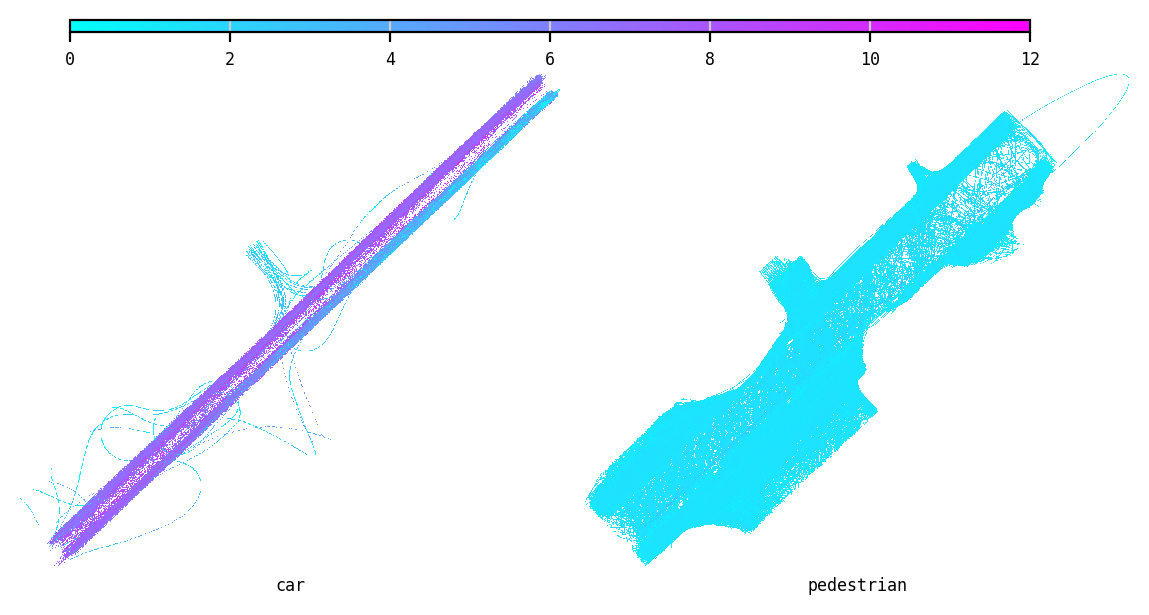

In [9]:
grids = []

fig = plt.figure(figsize=(6, 3))
gs = gridspec.GridSpec(1, 2, figure=fig)

axes = []
target_class = ["car", "pedestrian"]

for i, class_ in enumerate(target_class):
    row, col = divmod(i, 2)
    ax = fig.add_subplot(gs[row, col])

    df = (
        dfs
        .filter(pl.col("class") == class_)  # 👈 筛选 car
        .group_by(["y_bin", "x_bin"])
        .agg(pl.col("speed (m/s)").mean().alias("avg_speed"))
        .to_pandas()
    )

    grid = df.pivot(index="y_bin", columns="x_bin", values="avg_speed")
    
    sns.heatmap(
        grid,
        ax=ax,
        cmap="cool",
        cbar=False,
        xticklabels=False,
        yticklabels=False,
        vmin=0,
        vmax=12,
        square=True,
    )

    ax.set_aspect("equal")
    ax.set_xlabel(class_)
    ax.set_ylabel("")
    axes.append(ax)

cbar_ax = fig.add_axes([0.1, 0.94, 0.8, 0.02])
fig.colorbar(axes[-1].collections[0], cax=cbar_ax, orientation="horizontal")

fig.tight_layout(rect=[0.04, 0.02, 1, 0.9])
plt.show()

### Distribution of Speed by Trajectory Type

The scenarios in the uniD dataset represent typical low-speed traffic environments, where traffic participants often move at speeds close to zero. To more clearly illustrate the speed distribution in such settings, we apply a logarithmic scale to the y-axis. The visualization reveals significant variation in speed across different classes: vehicles (such as cars, trucks, trailers, buses, and vans) tend to travel much faster than vulnerable road users (VRUs) like pedestrians and animals. Additionally, there is considerable speed variation within each class. This diversity in speed profiles makes uniD a valuable resource for studying the behavior of traffic participants.

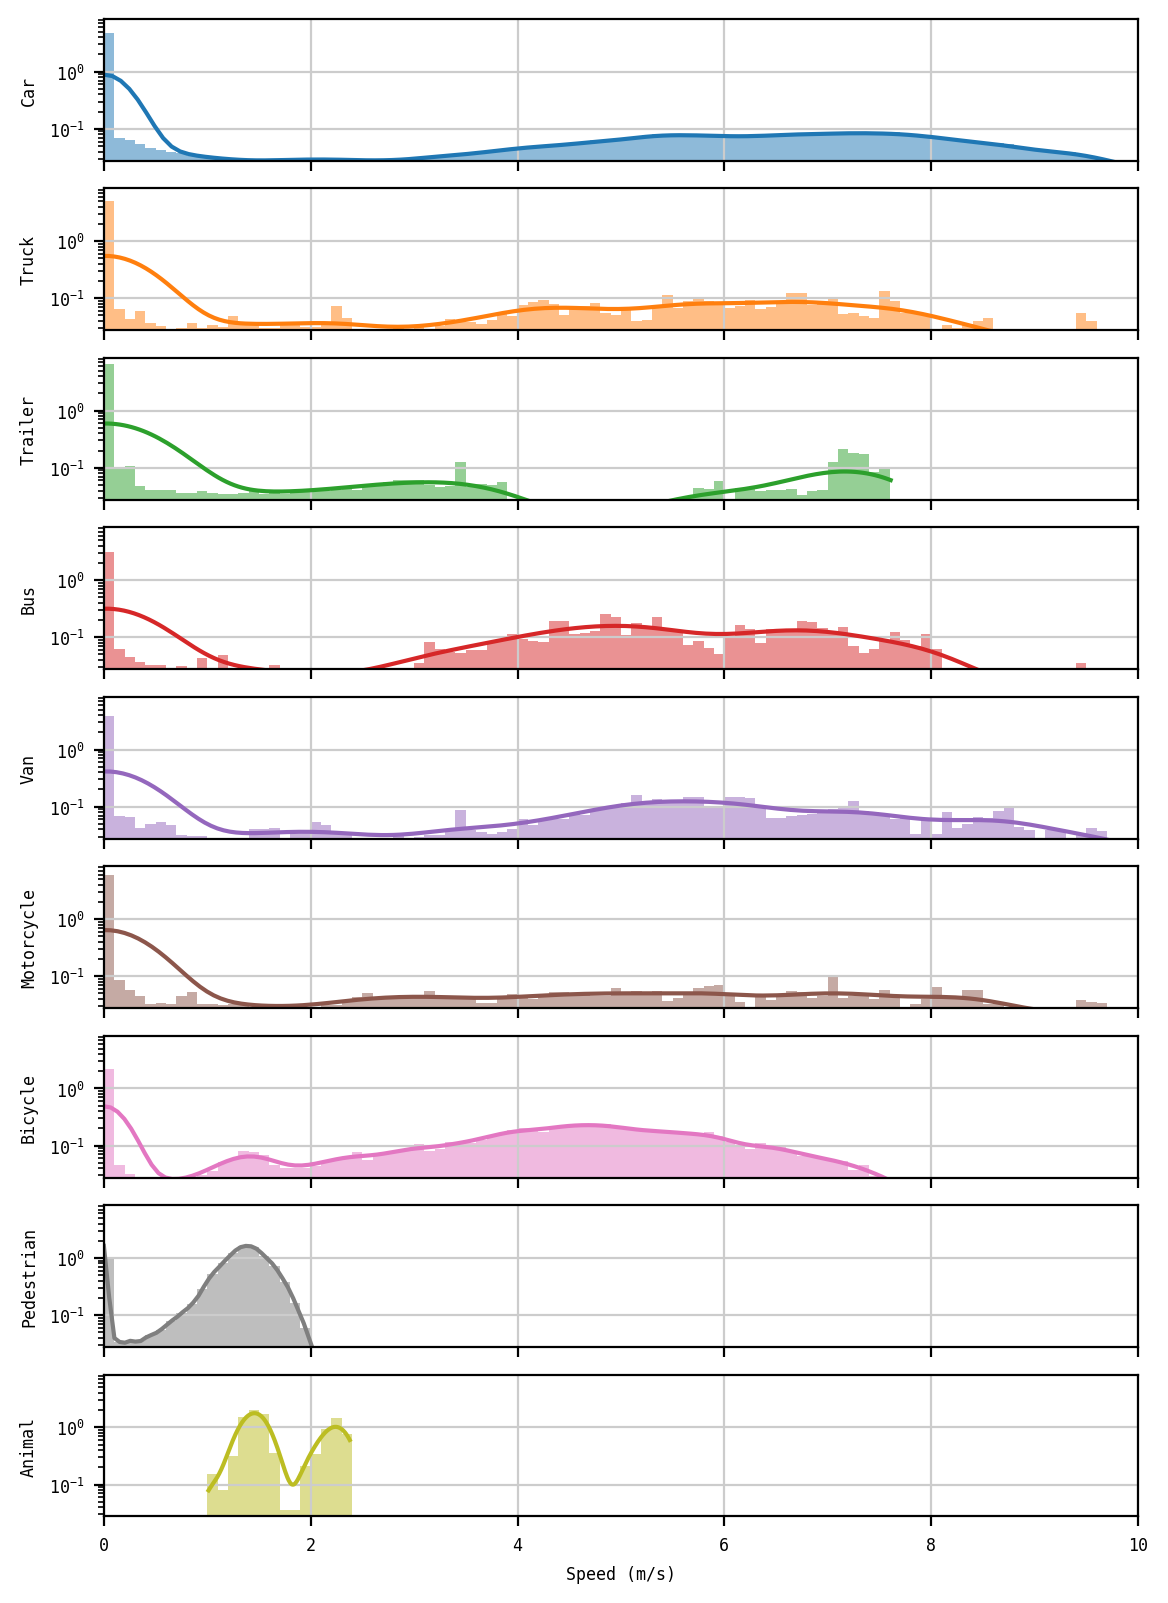

In [10]:
df_speed = dfs.to_pandas()

fig, axes = plt.subplots(9, 1, figsize=(6, 8), sharex=True, sharey=True)

for i, hue_class in enumerate(hue_order):
    ax = axes[i]

    df_class = df_speed[df_speed["class"] == hue_class]

    sns.histplot(
        df_class,
        x="speed (m/s)",
        stat="density",
        kde=True,
        log_scale=(False, True),
        binwidth=0.1,
        binrange=(0, 10),
        linewidth=0,
        alpha=0.5,
        ax=ax,
        color=sns.color_palette("tab10")[i],
    )

    ax.set_xlim([0, 10])
    ax.set_xlabel("Speed (m/s)")
    ax.set_ylabel(hue_class.capitalize())
    ax.set_yscale("log")

fig.tight_layout(rect=[0.03, 0, 1, 1])
plt.show()

## Tactics2D Integration

### Class Mapping

| Class | Tactics2D |
| --- | --- |
| car | `tactics2d.participant.element.Vehicle` |
| truck | `tactics2d.participant.element.Vehicle` |
| trailer | `tactics2d.participant.element.Vehicle` |
| bus | `tactics2d.participant.element.Vehicle` |
| van | `tactics2d.participant.element.Vehicle` |
| motorcycle | `tactics2d.participant.element.Cyclist`|
| bicycle | `tactics2d.participant.element.Cyclist`|
| pedestrian | `tactics2d.participant.element.Pedestrian` |
| animal | `tactics2d.participant.element.Other` |

In [11]:
# TODO: Migrate later

## Appendix: Data Format

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        This is a backup copy of 
        <a href="https://levelxdata.com/wp-content/uploads/2024/03/uniD-Format-1_1.pdf" target="_blank" rel="noopener noreferrer">
            the official documentation
        </a>, provided here for reference purposes only.
    </p>
</div>

The dataset includes measurement data extracted from one or more recording sites (locations) in the data directory as well as map files per location in the maps directory (if part of the dataset). Data and maps can be associated using a recording's location id. The data for each location is split into multiple continuous recordings.

In total four files are provided for each recording:

- An image of the recorded road section (XX_background.png)
- A csv file describing the recording location (XX_recordingsMeta.csv)
- A csv file containing an overview of recorded vehicle and VRU tracks (XX_tracksMeta.csv)
- A csv file for the tracks' trajectories (XX_tracks.csv)
    These files are created for each recording to ensure easy handling of the data.

In addition the following map data for each recording location are provided:

- Lanelet2 maps (.osm)
- ASAM OpenDrive maps (.xodr)
- 3D scene (.osgb & .fbx)

In the following, the dataset format and especially the meaning of every column is explained in
detail.

Please note that we summarize pedestrians, bicyclists and motorcycles to vulnerable road users
(VRUs) in the following tables.

### Image of the Road Section

For each recording a georeferenced image of the road section is added.The image is based on the recording itself by removing all moving vehicles through filtering. Additionally the resolution of the image was reduced.

### Recording Meta Information

This file contains metadata for each recording. The metadata provides a general overview, e.g. of the time of recording, the road section considered and the total number of objects tracked.

| Name | Description | Unit |
| --- | --- | --- |
| recordingId | The id of the recording. Every recording has a unique id. | [-] |
| locationId | The id of the recording location. | [-] | 
| frameRate | The frame rate which was used to record the video. | [hz] |
| speedLimit | The speed limit of the driving lanes. In all recordings, the speed limit is the same for every driving lane. | [m/s] |
| weekday | The weekday the recording was done. | [-] |
| startTime | The hour at which the recording was started | [hh] |
| duration | The duration of the recording. | [s] |
| numTracks | The number of objects tracked. | [-] |
| numVehicles | The number of vehicles tracked. | [-] |
| numVrus | The number of vulnerable road users (VRUs) tracked. | [-] |
| latLocation | Rough latitude coordinates of recording location. Not to be confused with UTM coordinates! | [deg] |
| lonLocation | Rough longitude coordinates of recording location. Not to be confused with UTM coordinates! | [deg] |
| xUtmOrigin | X value of UTM coordinate of origin of the local coordinate system for this recording location. Add this to xCenter to get UTM coordinates. | [m] |
| yUtmOrigin | Y value of UTM coordinate of origin of the local coordinate system for this recording location. Add this to yCenter to get UTM coordinates. | [m] |
| orthoPxToMeter | Scale factor from ortho image pixels to UTM meters. This value is needed for visualization. | [m/px] |
| exportVersion | Version of data format. (may be missing in some datasets) | [-] |

### Track Meta Information

This file contains an overview of all tracks.

The purpose of this file is to allow filtering tracks e.g. by class.

| Name | Description | Unit |
| --- | --- | --- |
| recordingId | The id of the recording. Every recording has a unique id. | [-] |
| trackId | The id of the track. The ids are assigned in ascending order for each recording. | [-] |
| initialFrame | The frame in which the track starts. | [-] |
| finalFrame | The frame in which the track ends. | [-] |
| numFrames | The total lifetime in frames. | [-] |
| width | The width of the tracked object. This property is set to zero for VRUs. | [m] |
| length | The length of the tracked object. This property is set to zero for VRUs. | [m] |
| class | The class of the tracked object. | [-] |

### Tracks

This file contains all time dependent values for each track. Information such as current position, velocity and acceleration.

| Name | Description | Unit |
| --- | --- | --- |
| recordingId | The id of the recording. Every recording has a unique id. | [-] |
| trackId | The track's id. The ids are assigned in ascending order for each recording. | [-] |
| frame | The frame for which the information are given. | [-] |
| trackLifetime | The current age of the track at this frame. | [-] |
| xCenter | The x position of the object's centroid in the local coordinate system. Add xUtmOrigin to get UTM coordinates. | [m] |
| yCenter | The y position of the object's centroid in the local coordinate system. Add yUtmOrigin to get UTM coordinates. | [m] |
| heading | The heading in the local coordinate system. | [deg] |
| width | The width of the object. This property is set to zero for VRUs. | [m] |
| length | The height of the object. This property is set to zero for VRUs. | [m] |
| xVelocity | The velocity in x-axis direction in the local coordinate system. | [m/s] |
| yVelocity | The velocity in y-axis direction in the local coordinate system. | [m/s] |
| xAcceleration | The acceleration in x-axis direction in the local coordinate system. | [m/s²] |
| yAcceleration | The acceleration in y-axis direction in the local coordinate system. | [m/s²] |
| lonVelocity | The longitudinal velocity. | [m/s] |
| latVelocity | The lateral velocity. | [m/s] |
| lonAcceleration | The longitudinal acceleration. | [m/s²] |
| latAcceleration | The lateral acceleration. | [m/s²] |

### Coordinate System

The global coordinate system used is the UTM coordinate system, as we geo-referenced our data. For easier handling of data of the same intersection in different recordings, we introduced a local UTM-like coordinate system.

The only difference is, that the origin (0, 0) is very close to the recorded road section and the same for all recordings at each location.

To transform positions into the global UTM coordinate system, just add xUtmOrigin and yUtmOrigin to all positions.

The local coordinate system looks as follows: The horizontal axis is the x-axis, which grows to the right.

The vertical axis is the y-axis, which grows upwards.

The heading is calcuated as in the UTM coordinate system.

Finally, we use SI units only.

![The coordinate system of uniD dataset](https://raw.githubusercontent.com/MotacillaAlba/image-storage/main/img/inD-coordinate-system.png)